# A Universidade de Montana

A universidade de Montana, nos Estados Unidos, possui vários serviços de apoio ao aluno, incluindo uma biblioteca.

A biblioteca da universidade oferece vários serviços para os estudantes, como alocação de salas de estudos, livros, computadores, discussões em grupo, webnários etc. Todos esses serviços e vários outros, ficam disponíveis dentro da página web da própria biblioteca e os alunos podem acessá-la para agendar algum dos serviços disponíveis.

A página possui um banner da universidade, uma barra de busca, três principais categorias de acesso e uma barra lateral direita que exibe as últimas notícias.

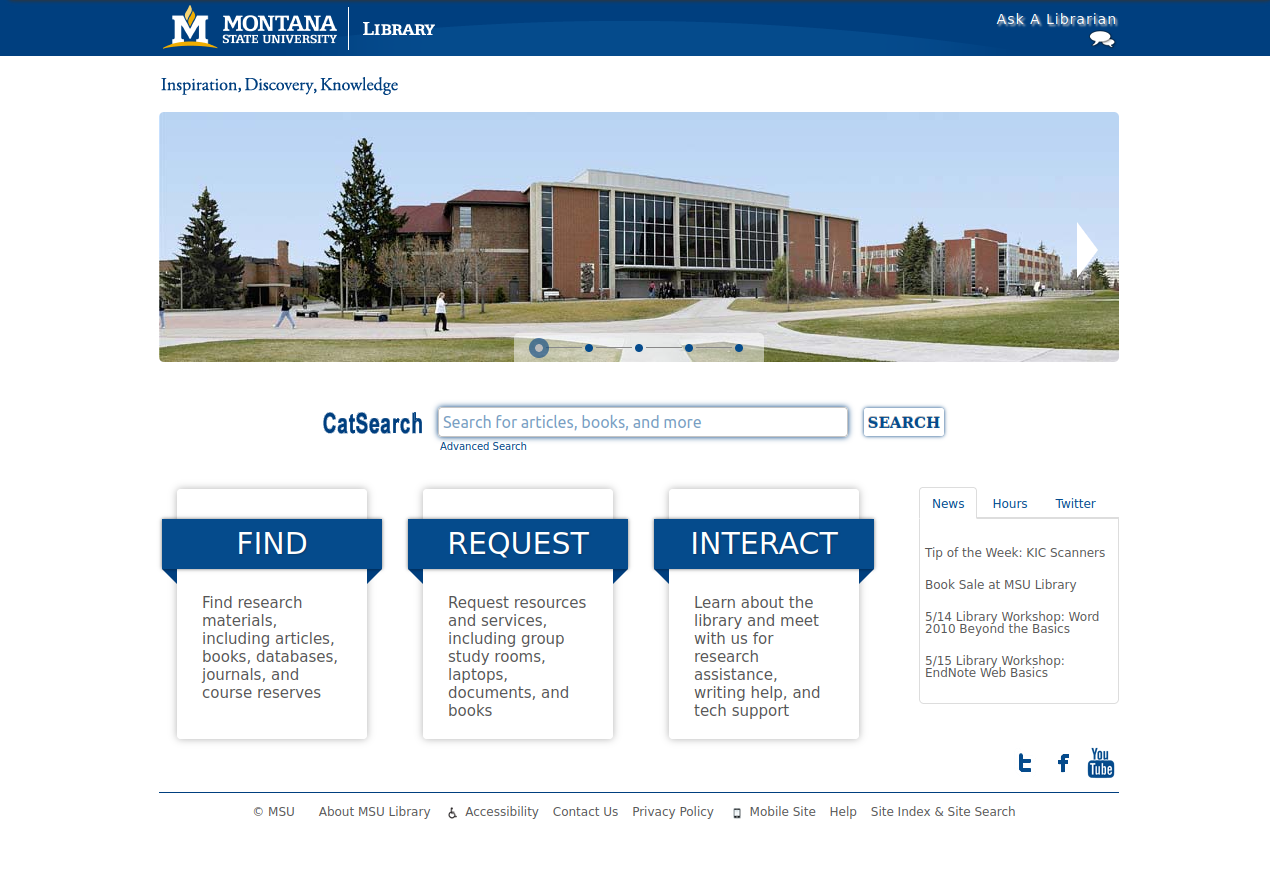

In [70]:
Image("img/montana_uni_lib.png")

Durante o período de 3 de Abril de 2013 até 10 de Abril de 2013, a página "home" da biblioteca recebeu 10.819 visitantes. Ao analisar os dados de acesso da página, o time de TI da universidade percebeu uma grande diferença entre os acessos das categorias das páginas. A taxa de click da "Find" foi de 35%, "Request" foi de 6% e "Interact" foi de 2%.

Olhando para as taxas de clicks, o time de TI se perguntou o motivo da conversão da categoria "Interact" estar tão baixa.

Uma das hipóteses do time de TI foi de que o nome "Interact" está confundindo os alunos, pois não deixa claro o propósito daquela categoria. Assim, quatro novos nomes foram propostos para substituir o nome atual da categoria: "Connect", "Lean", "Help" e "Service".

Com as variações do nome da categoria, um teste A/B/n precisa ser definido para validar qual das variações deixa a categoria mais compreensível e atraente para os estudantes, com a expectativa de aumentar a taxa de clicks nessa categoria.

Assim, durante 3 semanas, entre os dias 29 de Maio de 2013 e 18 de Junho de 2013, foi realizado um teste A/B/n. O experimento foi desenhado para garantir que um usuário acessasse qualquer uma das variações com a mesma probabilidade.

# Planejamento da Solução

**Input - Output - Tasks**

_Input_:
- Conjunto de dados
- Problema de negócio

_Output_:
- E-mail

_Tasks_:
- Teste de Hipótese
- Definir o método de inferência estatística (ANOVA, t-test, Chi-Squared)
- Design de Experimento
    - Hipóteses
    - Tamanho da Amostra
    - Efeito esperado

## 0.1 Imports

In [69]:
import pandas as pd
import numpy as np

from statsmodels.stats.gof import chisquare_effectsize
from statsmodels.stats.power import TTestIndPower
from statsmodels.sandbox.stats.multicomp import multipletests

from scipy import stats
from itertools import combinations
from IPython.display import Image

## 0.2 Load data

In [68]:
# informações extraídas dos arquivos obtidos no Google Analytics (Homepage Version 1~5)
d = {'variant': ['interact', 'connect', 'learn', 'help', 'services'],
     'visits': [10283, 2742, 2747, 3180, 2064],
     'clicks_all': [3714, 1587, 1652, 1717, 1348],
     'clicks_link': [42, 53, 21, 38, 45]}

data = pd.DataFrame(d)
data['conversion'] = data['clicks_link']/data['clicks_all']

data

,variant,visits,clicks_all,clicks_link,conversion
0,interact,10283,3714,42,0.011309
1,connect,2742,1587,53,0.033396
2,learn,2747,1652,21,0.012712
3,help,3180,1717,38,0.022132
4,services,2064,1348,45,0.033383


# 1.0 Escolha do método

O método para identificar um efeito dentre as 4 variantes será: **A/B/n testing**

# 2.0 Design de Experimentos

## 2.1 Formulação das hipótese

Hipótese nula (H0): Não há diferença entre as variantes.

Hipótese alternativa (H1): Há uma diferença entre as variantes.

## 2.2 Parâmetros do experimento

Nível de confiança do experimento: **95%**

Métrica de avaliação: **CTR (Click-Through Rate)**

    CTR = Total de Clicks no link / Total de Clicks na página
    
Poder Estatístico: **80%**

In [33]:
k = len(data['clicks_all'])

# distribuição da probabilidade na hipotese nula
expected_dist = [1/k]*k # a porcentagem de clicks não é diferente entre as variantes

actual_dist = data['clicks_link']/data['clicks_link'].sum()

In [39]:
# nível de significância
alpha = 0.05

# poder estatístico
power = 0.80

# tamanho do efeito - Efeito Qui Quadrado
effect_size = chisquare_effectsize(expected_dist, actual_dist)

# Tamanho da amostra para uma variante
sample_size = TTestIndPower().solve_power(
    effect_size=effect_size,
    power=power,
    alpha=alpha
)

sample_size = np.ceil(sample_size).astype(int)
print(f'Tamanho de Amostra Mínimo por Variante: {sample_size}')
print(f'Tamanho de Amostra Total: {sample_size*k}')

Tamanho de Amostra Mínimo por Variante: 222
Tamanho de Amostra Total: 1110


# 3.0 Aplicação do Teste Chi-Squared

In [43]:
# calculando clicks que não foram no link
data['no_clicks_link'] = data['clicks_all'] - data['clicks_link']
df = data[['variant', 'no_clicks_link', 'clicks_link']]

# criando a tabela de contingência
df = df.set_index('variant')

In [51]:
chi2, pvalue, dof, expected = stats.chi2_contingency(df)
print(f'Chi-Squared: {chi2} - p-value: {pvalue}')

if pvalue < alpha:
    print(f'A hipótese nula é rejeitada, há diferença significativa entre as variantes.')
else:
    print('Não há dados suficientes para rejeitar a hipótese nula.')

Chi-Squared: 46.33660181942126 - p-value: 2.0959498129984563e-09
A hipótese nula é rejeitada, há diferença significativa entre as variantes.


# 4.0 Post-hoc Testing

In [63]:
all_combinations = list(combinations(df.index, 2))
p_values = []

# Aplicando o teste de qui quadrado para cada combinação possivel
for comb in all_combinations:
    new_df = df[(df.index == comb[0]) | (df.index == comb[1])]
    chi2, pvalue, dof, ex = stats.chi2_contingency(new_df)
    p_values.append(pvalue)
    
# Corrigindo o p-valor pela Correção de Bonferroni
reject_list, corret_p_values = multipletests(p_values, method='bonferroni')[:2]

In [64]:
frame = {'combinations': all_combinations,
         'original_pvalue': p_values,
         'correted_pvalue': corret_p_values,
         'reject': reject_list}

# tabela com os p-valores originais e corrigidos de todas as combinações
pd.DataFrame(frame)

,combinations,original_pvalue,correted_pvalue,reject
0,"(interact, connect)",5.367677e-08,5.367677e-07,True
1,"(interact, learn)",7.616981e-01,1.000000e+00,False
2,"(interact, help)",3.103059e-03,3.103059e-02,True
3,"(interact, services)",1.798089e-07,1.798089e-06,True
4,"(connect, learn)",1.329287e-04,1.329287e-03,True
5,"(connect, help)",6.144184e-02,6.144184e-01,False
6,"(connect, services)",1.000000e+00,1.000000e+00,False
7,"(learn, help)",5.089582e-02,5.089582e-01,False
8,"(learn, services)",2.037404e-04,2.037404e-03,True
9,"(help, services)",7.301999e-02,7.301999e-01,False


Com a tabela acima, observamos que há diferença significativa (rejeitamos a hipótese nula de que não há diferença) entre a página atual (Interact) e as páginas:
* Connect
* Help
* Services

Comparando as variantes que apresentaram diferença, vemos que **não há diferença significativa entre as variantes**.

Assim, a recomendação para mudança da página segue a ordem de maior conversão e menor p-valor:
1. Connect
2. Services
3. Help